# Regridding (Part2)

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe
from xgcm.autogenerate import generate_grid_ds
from xgcm import Grid

Set range of longitude/latitude and the rsolution of grid we want.

We use 1 degree this time for comparing with `Regridding_1` part.

In [2]:
resolution = 1 # degree
Lat_min = 20; Lat_max = 50
Lon_min = -115; Lon_max = -65

Read file and drop time dimension.
We need to rename the coordinate names to `lon` and `lat` because xESMF has no way to guess variable meaning.

In [3]:
filename = 'wrfout_d01_2014-08-31_22:30:00'
ds = xr.open_dataset(filename).isel(Time=0)
ds.rename({'XLONG':'lon','XLAT':'lat'}, inplace=True)

<xarray.Dataset>
Dimensions:        (bottom_top: 39, bottom_top_stag: 40, south_north: 344, south_north_stag: 345, west_east: 429, west_east_stag: 430)
Coordinates:
    lat            (south_north, west_east) float32 ...
    XLAT_U         (south_north, west_east_stag) float32 ...
    XLAT_V         (south_north_stag, west_east) float32 ...
    lon            (south_north, west_east) float32 ...
    XLONG_U        (south_north, west_east_stag) float32 ...
    XLONG_V        (south_north_stag, west_east) float32 ...
Dimensions without coordinates: bottom_top, bottom_top_stag, south_north, south_north_stag, west_east, west_east_stag
Data variables:
    CG_FLASHCOUNT  (south_north, west_east) float32 ...
    COSALPHA       (south_north, west_east) float32 ...
    HGT            (south_north, west_east) float32 ...
    IC_FLASHCOUNT  (south_north, west_east) float32 ...
    P              (bottom_top, south_north, west_east) float32 ...
    PB             (bottom_top, south_north, west_eas

Create the nested grid we want

In [4]:
nested_grid = xe.util.grid_2d(Lon_min-resolution, Lon_max+resolution, resolution,  # longitude boundary range and resolution
                        Lat_min-resolution, Lat_max+resolution, resolution)  # latitude boundary range and resolution
nested_grid

<xarray.Dataset>
Dimensions:  (x: 52, x_b: 53, y: 32, y_b: 33)
Coordinates:
    lon      (y, x) float64 -115.5 -114.5 -113.5 -112.5 -111.5 -110.5 -109.5 ...
    lat      (y, x) float64 19.5 19.5 19.5 19.5 19.5 19.5 19.5 19.5 19.5 ...
    lon_b    (y_b, x_b) int64 -116 -115 -114 -113 -112 -111 -110 -109 -108 ...
    lat_b    (y_b, x_b) int64 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

## Bilinear regridding

In [5]:
regridder_bilinear = xe.Regridder(ds, nested_grid, method='bilinear')

Create weight file: bilinear_344x429_32x52.nc


 Loop over all variables in an xarray Dataset and choose what we want.

In [6]:
Bilinear_list = [] # an emtpy list to hold regridding result

for varname, dr in ds.data_vars.items():
  # Olny pick variables we need
  if varname in ['IC_FLASHCOUNT','CG_FLASHCOUNT','no2']:
    dr_temp = regridder_bilinear(dr)  # temporary variable for the current tracer
    Bilinear_list.append(dr_temp)

Bilinear_list

[<xarray.DataArray 'CG_FLASHCOUNT' (y: 32, x: 52)>
 array([[ 764.521604,  748.636396,  511.143155, ...,    0.      ,    0.      ,
            0.      ],
        [ 180.884656,  727.697521,  629.781586, ...,    0.      ,    0.      ,
            0.      ],
        [ 289.223857,  393.361913,  557.536427, ...,    0.      ,    0.      ,
            0.      ],
        ...,
        [ 126.277751,   90.604129,   68.304105, ..., 1388.713025, 1778.016606,
          754.325518],
        [ 177.508834,  100.436786,  165.092154, ...,   18.27568 ,   34.851121,
           18.907848],
        [ 254.735661,  348.349837,  142.618293, ...,  669.033203,  521.386937,
          323.158809]])
 Coordinates:
     lon      (y, x) float64 -115.5 -114.5 -113.5 -112.5 -111.5 -110.5 -109.5 ...
     lat      (y, x) float64 19.5 19.5 19.5 19.5 19.5 19.5 19.5 19.5 19.5 ...
 Dimensions without coordinates: y, x
 Attributes:
     regrid_method:  bilinear,
 <xarray.DataArray 'IC_FLASHCOUNT' (y: 32, x: 52)>
 array([[  0.   

We can merge a list of DataArray to a single Dataset

In [7]:
Bilinear_result = xr.merge(Bilinear_list)  # merge a list of DataArray to a single Dataset
# NOTE: The next version of xESMF (v0.2) will be able to directly regrid a Dataset, 
# so you will not need those additional code. But it is a nice coding exercise anyway.
Bilinear_result

<xarray.Dataset>
Dimensions:        (bottom_top: 39, x: 52, y: 32)
Coordinates:
    lon            (y, x) float64 -115.5 -114.5 -113.5 -112.5 -111.5 -110.5 ...
    lat            (y, x) float64 19.5 19.5 19.5 19.5 19.5 19.5 19.5 19.5 ...
  * bottom_top     (bottom_top) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
Dimensions without coordinates: x, y
Data variables:
    CG_FLASHCOUNT  (y, x) float64 764.5 748.6 511.1 0.0 0.0 0.0 0.0 0.0 0.0 ...
    IC_FLASHCOUNT  (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    no2            (bottom_top, y, x) float64 6.651e-07 6.214e-06 5.015e-06 ...

Calculate a new variable and save it to Dataset

In [8]:
Bilinear_result['TL_FLASHCOUNT'] =  Bilinear_result.CG_FLASHCOUNT + Bilinear_result.IC_FLASHCOUNT #TL  = IC +CG

it's good practice to supply array attributes such as `units` and description.

In [9]:
# Set attributes
Bilinear_result['no2'].attrs['description'] = 'NO2 mixing ratio'
Bilinear_result['no2'].attrs['units'] = 'ppmv'
Bilinear_result['IC_FLASHCOUNT'].attrs['description'] = 'Accumulated IC flash count'
Bilinear_result['CG_FLASHCOUNT'].attrs['description'] = 'Accumulated CG flash count'
Bilinear_result['TL_FLASHCOUNT'].attrs['description'] = 'Accumulated Total flash count'

## Conservative regridding

To use conservative regridding, you need to specify the cell boundaries, since the boundary information is needed for calculating overlapping areas (thus ensures total mass conservation).

I decide to converting 2D coordinates from cell center to bound with [xgcm.autogenerate](https://gist.github.com/jbusecke/175d72d81e13f7f8d4dcf26aace511bd).

In [10]:
# Generate outer dimensions from center input
ds_post = generate_grid_ds(ds, {'X':'west_east', 'Y':'south_north'}, position=('center', 'outer'))

# Generate the 2d coordinates for the cell boundaries
# with the "standard" xgcm interpolation for each logical dimension
grid_ds = Grid(ds_post, periodic=False)
bnd='extrapolate'
ds_post.coords['xb'] = grid_ds.interp(grid_ds.interp(ds_post['lon'], 'X', boundary=bnd, fill_value=np.nan),
                                          'Y', boundary=bnd, fill_value=np.nan)
ds_post.coords['yb'] = grid_ds.interp(grid_ds.interp(ds_post['lat'], 'X', boundary=bnd, fill_value=np.nan),
                                          'Y', boundary=bnd, fill_value=np.nan)

wrf_grid_with_bounds = {'lon': ds['lon'].values,
                         'lat': ds['lat'].values,
                         'lon_b': ds_post.xb.data,
                         'lat_b': ds_post.yb.data,
                       }

regridder_conserve = xe.Regridder(wrf_grid_with_bounds, nested_grid, method='conservative')

Create weight file: conservative_344x429_32x52.nc


Like before, we can regrid and create Dataset now

In [11]:
Conservative_list = []

for varname, dr in ds.data_vars.items():
  if varname in ['IC_FLASHCOUNT','CG_FLASHCOUNT','no2']:
    dr_temp = regridder_conserve(dr)
    Conservative_list.append(dr_temp)

Conservative_result = xr.merge(Conservative_list)

Conservative_result['TL_FLASHCOUNT'] =  Conservative_result.CG_FLASHCOUNT + Conservative_result.IC_FLASHCOUNT

# Set attributes
Conservative_result['no2'].attrs['description'] = 'NO2 mixing ratio'
Conservative_result['no2'].attrs['units'] = 'ppmv'
Conservative_result['IC_FLASHCOUNT'].attrs['description'] = 'Accumulated IC flash count'
Conservative_result['CG_FLASHCOUNT'].attrs['description'] = 'Accumulated CG flash count'
Conservative_result['TL_FLASHCOUNT'].attrs['description'] = 'Accumulated Total flash count'

## Comparasion

Comparing two algorithms:

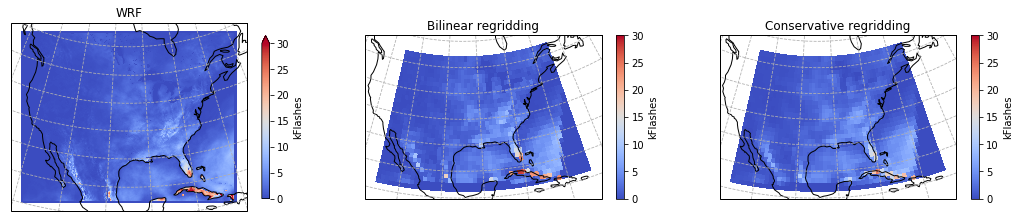

In [12]:
# Create Lambert Projection
proj = ccrs.LambertConformal(central_latitude=39,central_longitude=-95,
                            standard_parallels = (39, 39))

fig, axes = plt.subplots(1, 3, figsize=[18,6], subplot_kw={'projection': proj})

TL = (ds['CG_FLASHCOUNT']+ds['IC_FLASHCOUNT'])/1E3 # kFlashes
TL_Bilinear = Bilinear_result['TL_FLASHCOUNT']/1E3
TL_Conservative = Conservative_result['TL_FLASHCOUNT']/1E3

# Plot WRF data
TL.plot(ax=axes.flatten()[0], cmap='coolwarm', transform=ccrs.PlateCarree(), x='lon', y='lat', vmin=0, vmax=30,
                        cbar_kwargs={'shrink': 0.5, 'label': 'kFlashes'})

# Plot Bilinear data
TL_Bilinear.plot(ax=axes.flatten()[1], cmap='coolwarm', transform=ccrs.PlateCarree(), x='lon', y='lat', vmin=0, vmax=30,
                                   cbar_kwargs={'shrink': 0.5, 'label': 'kFlashes'})

# Plot Conservative data
TL_Conservative.plot(ax=axes.flatten()[2], cmap='coolwarm', transform=ccrs.PlateCarree(), x='lon', y='lat', vmin=0, vmax=30,
                                      cbar_kwargs={'shrink': 0.5, 'label': 'kFlashes'})

axes.flatten()[0].set_title('WRF')
axes.flatten()[1].set_title('Bilinear regridding')
axes.flatten()[2].set_title('Conservative regridding')

for ax in axes.flatten():
    ax.coastlines()
    ax.gridlines(linestyle='--')

For 1 degree, both kinds of regridding fails.

Because `TL_FLASHCOUNT` is total lightning flashcounts, it should be larger if regridded to 1 degree instead of original 12 km.

Should I regrid to 0.1 degree first and use [scipy.stats.binned_statistic_2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binned_statistic_2d.html) to calculate the sum of flashcounts?